In [1]:
def param_dict():
    params = {
        "factor0": 0.0,
        "factor1": 0.0,
        "factor2": 0.0,
        "factor3": 0.0,
        "gridpoints": 0,
        "routine": "1vN"
    }
    return params

def fill_param_dict(params, factor, points, method):
    params['factor0'] = factor
    params['factor1'] = factor
    params['factor2'] = factor
    params['factor3'] = factor
    params['gridpoints'] = points
    params['routine'] = method
    


In [54]:
import setup as set
import data_directory as dd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
from matplotlib import cm
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

def theta01_sweep_calc_load(t_set, factor, points, recalcuate=False):
    # create some sample data
    dphi = 1e-2
    X, Y = np.meshgrid(np.linspace(-dphi, np.pi+dphi, points), np.linspace(-dphi, np.pi+dphi, points))

    t_set.factor0 = factor
    t_set.factor1 = factor
    t_set.factor2 = factor
    t_set.factor3 = factor

    params_dict = param_dict()
    fill_param_dict(params_dict, factor, points, t_set.method)

    Z = dd.load_data(params_dict, '0_current-after-blockade')
    if recalcuate:
        Z = None
    
    if Z is None:
        Z = np.abs(np.array([current_calculation(t_set, X[idx], Y[idx], idx) for idx, dummy in np.ndenumerate(X) ] ).reshape(X.shape+(2,) ) )
        dd.save_data(Z, params_dict, '0_current-after-blockade')

    return X, Y, Z


def current_calculation(t_set, x, y, idx):
    print(idx)
    t_set.th0 = x
    t_set.th1 = y
    detuning = 1e-6

    blockade_result = t_set.adjust_to_z_blockade()
    print(blockade_result.fun)
    if blockade_result.fun > 1e-6:
        # Print some overextensive and long warning that can't be missed
        print("WARNING: Blockade not reached! Current calculation might be wrong!")
    gamma_0 = t_set.gamma_00
    gamma_1 = t_set.gamma_01
    t_set.gamma_02 = detuning

    t_set.gamma_01 = detuning
    t_set.gamma_00 = gamma_0
    t_set.initialize_box()
    t_set.connect_box()
    sys = t_set.build_qmeq_sys()
    sys.solve(qdq=False, rotateq=False)
    current	 = sys.current[0]

    t_set.gamma_01	= gamma_1
    t_set.gamma_00	= detuning
    t_set.initialize_box()
    t_set.connect_box()
    sys = t_set.build_qmeq_sys()
    sys.solve(qdq=False, rotateq=False)
    return [current, sys.current[0]]

def theta0_variation_plot(fig, ax, t_set, thetas):
    current_0	= []
    current_1	= []
    for theta in thetas:
        t_set.th0	= theta
        t_set.adjust_to_z_blockade()
        gamma_0		= t_set.gamma_00
        gamma_1		= t_set.gamma_01

        t_set.gamma_01	= 0
        t_set.initialize_box()
        t_set.connect_box()
        sys	= t_set.build_qmeq_sys()
        sys.solve(qdq=False, rotateq=False)
        current_0.append(sys.current[0] )

        t_set.gamma_01	= gamma_1
        t_set.gamma_00	= 0.0
        t_set.initialize_box()
        t_set.connect_box()
        sys	= t_set.build_qmeq_sys()
        sys.solve(qdq=False, rotateq=False)
        current_1.append(sys.current[0] )


    current	= np.transpose(np.array([current_0, current_1]) )

    ax.scatter(thetas, current[:,0], marker='x', label='site 0' )
    ax.scatter(thetas, current[:,1], marker='x', label='site 1' )
    thetas	= np.linspace(0, np.pi, 1000)

    ax.plot(thetas, np.transpose(func(thetas)[2] ), label='analytics' )
    ax.legend()

def func(theta):
    gamma_plus	= 2*(1+np.sin(theta))/np.abs(np.cos(theta) )
    gamma_minus	= 2*(1-np.sin(theta))/np.abs(np.cos(theta) )
    gamma_drain	= 4
    gamma_eff	= np.abs(np.cos(theta) )
    gamma_eff	= 1/(1/gamma_plus+1/gamma_minus+2/gamma_drain)
    return np.array([gamma_plus, gamma_minus, 2*gamma_eff] )

params_dict = param_dict()

def theta01_sweep_plot(fig, axes, t_set, points, fs, recalcuate=False, vmin=None, vmax=None, cmap=cm.jet):
    factor = 1.0
    ax = axes[0]
    #dd.save_data(data_set, params_dict, '0_current-after-blockade'
    
    X, Y, data_set = theta01_sweep_calc_load(t_set, factor, points, recalcuate=recalcuate)

    daten = np.abs((data_set[:,:,0]-data_set[:,:,1])/(data_set[:,:,0]+data_set[:,:,1]) )
    # Print the maximum and minimum values of the data set
    print("Maximum value: ", daten.max() )
    print("Minimum value: ", daten.min() )
    # Create a logarithmic colorbar plot of the data
    if vmin is None:
        vmin = daten.min()
    if vmax is None:
        vmax = daten.max()
    c = ax.pcolormesh(X, Y, daten, norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    # Alternative colormaps to jet: viridis, plasma, inferno, magma, cividis
    # Is there a inverted jet colormap? A:

    # Set axis labels and title
    ax.set_xlabel(r"$\theta_0$", size=fs)
    ax.set_ylabel(r"$\theta_1$", size=fs)

    # Create colorbar
    cb = fig.colorbar(c)

    cb.ax.set_title(r"$\Delta I/I_{tot}$", size=fs)
    # cb.ax.locator_params(axis='y', nbins=4 )
    cb.ax.tick_params(labelsize=fs)
    ticks = np.arange(0, np.pi+1, np.pi/2)
    tick_labels = ['0', r'$\pi/2$', r'$\pi$']
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.tick_params(labelsize=fs)

Loading data from:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0_current-after-blockade/data_factor0-1.0_factor1-1.0_factor2-1.0_factor3-1.0_gridpoints-101_routine-py1vN.npy
Data loaded from:  /Users/ma0274ni/Documents/projects/majorana_box/data/fusion_rule/format_0_current-after-blockade/data_factor0-1.0_factor1-1.0_factor2-1.0_factor3-1.0_gridpoints-101_routine-py1vN.npy
Maximum value:  0.9999998527264328
Minimum value:  9.960395025423126e-07


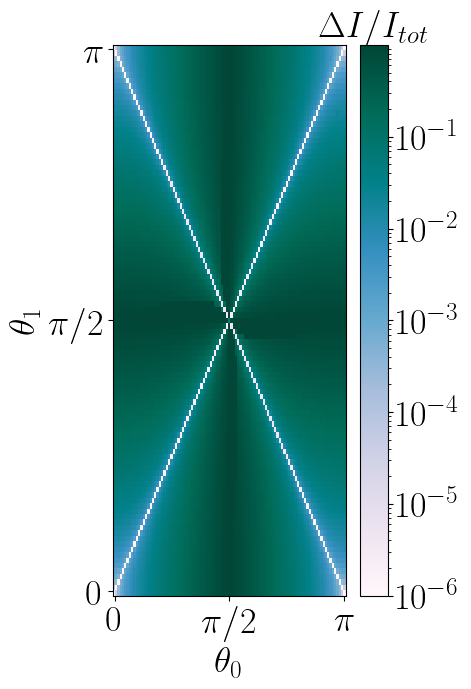

In [63]:
import importlib
importlib.reload(dd)
importlib.reload(set)

zmax = 1.1
zmin = 1e-8
points = 101
fs = 26
recalcuate = False

t_set = set.create_transport_setup()
t_set.initialize_leads()
t_set.model = 2
t_set.eps01 = 0*1.0e-6
t_set.eps12 = 0*1.5e-6
t_set.eps23 = 0*2.0e-6

fig, axes = plt.subplots(1,1, figsize=(4.7,7))
theta01_sweep_plot(fig, [axes], t_set, points, fs, recalcuate=recalcuate, vmin=None, vmax=None, cmap=cm.PuBuGn)
fig.tight_layout()
#Save created plot as regular picture
#plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_different_current_f0=f1=f2=f3-1.0-0.5-0.25_gridpoints-100_1vN.pdf', format='pdf')
#Save created plot as finite zmin, zmax
plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_different_current_gridpoints-101_no-bounds_1vN.pdf', format='pdf')
plt.savefig('/Users/ma0274ni/Documents/projects/majorana_box/papers/fusion/plots/ABS-box_different_current_gridpoints-101_no-bounds_1vN.png', format='png', dpi=300)

plt.show()